##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
importlib.reload(Dense)
importlib.reload(RSTF)

%matplotlib inline
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from ipywidgets import FloatProgress
from IPython.display import display
import os  

In [3]:
def Curve(x,a,b,c,o):
    return (a/(b+x)**c+o)

# def Curve(x,a,b,c):
#     return (a*x**2+b*x+c)

def Combos(Model,L,factor=None):
    Models=list()
    for c in combinations(Model,L):
        c = list(c)
        if factor is None:
            Models.append(c)
        else:
            for f in factor:
                f = f.split('+')
                if set(f).issubset(set(c)) and c not in Models:
                    Models.append(c)
    return(Models)

def TTV_Split(iteration,Memory,X,y,params,X_fill):
    params['seed'] = int(iteration%params['splits_per_mod']/params['splits_per_mod']*100)
    params['iteration'] = int(iteration/params['splits_per_mod'])
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=params['seed'])
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=params['seed'])
    return(Dense.Train_Steps(params,X_train,X_test,X_val,y_train,y_test,
        y_val,X_fill = X_fill,Memory=Memory),
        y_val)

def RunReps(Model,params,pool = None,FullReturn=False):
    RST = RSTF.ReadStandardTimeFill(params['Dpath']+'ECData.csv')
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    if params['T'] >0:
        RST.TimeShape(params['T'])
    y = RST.y*1.0
    X = RST.X*1.0
    X_fill = RST.X_fill*1.0
    MSE = []
    R2 =[]
    Y_fill = []
    Yval = []
    y_val= []
    if __name__=='__main__'and params['proc'] != 1:
        for i,results in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params,X_fill=X_fill),range(params['K']))):
            Y_fill.append(results[0][0])
            Yval = RST.YScaled.inverse_transform(results[0][1].reshape(-1,1))
            y_val = RST.YScaled.inverse_transform(results[1].reshape(-1,1))
            MSE.append(metrics.mean_squared_error(Yval,y_val))
            R2.append(metrics.r2_score(Yval,y_val))
    else:
        for i in range(params['K']):
            results = TTV_Split(i,Memory,X,y,params,X_fill)
            Y_fill.append(results[0][0])
            Yval = RST.YScaled.inverse_transform(results[0][1].reshape(-1,1))
            y_val = RST.YScaled.inverse_transform(results[1].reshape(-1,1))
            MSE.append(metrics.mean_squared_error(y_val,Yval))
            R2.append(metrics.r2_score(y_val,Yval))
    Y_fill = np.asanyarray(Y_fill)
    Y_fill = Y_fill.mean(axis=0) 
    FillVarName = FillVar.replace('f','F')
    RST.Fill(Y_fill,FillVarName)
    return(MSE,R2,RST.Master['TempFill'])

def RunLoop(Runs,model):
    
    style = {'description_width': 'initial'}
    f = FloatProgress(min=0, max=Runs['N'].count(),description='Finding Best N:',style=style) # instantiate the bar
    display(f) # display the bar
    for N in Runs['N'].unique():
        params['T'] = 0
        params['N']=N
        Results = RunReps(model,params,pool)
        MSE = Results[0]
        R2 = Results[1]
        Runs.loc[Runs['N']==N,'MSE']=MSE
        Runs.loc[Runs['N']==N,'R2']=R2
        f.value+=params['K']
    return(Runs)

def N_Nodes(Runs,params,model,plot=False):
    Runs = RunLoop(Runs,model)
    Group = Runs.groupby('N').mean()
    Group['SD'] = Runs[['N','MSE']].groupby('N').std()
    Group['SE'] = Runs[['N','MSE']].groupby('N').sem()
    Min = Group.loc[Group['MSE']==Group['MSE'].min()]
    popt, pcov = curve_fit(Curve, Runs['N'].values, Runs['MSE'].values)
    N = np.arange(Runs['N'].min(),Runs['N'].max())
    Fit = Curve(N,*popt)
    Max = (Min['MSE']+Min['SE']).values[0]
    try:
        params['N']=N[Fit<Max].min()
    except:
        params['N']=N[-1]
        pass
    
    if plot == True:
        fig,ax = plt.subplots(figsize=(8,8))
        ax.scatter(Runs['N'],Runs['MSE'])
        ax.plot(N,Fit,color='r')
        ax.plot(N,N*0+Max,color = 'black')
        plt.grid()
        plt.show()
        print(params['N'])
    return(params)

def FactorTest(params,FullModel,Runs):
    prog1 = FloatProgress(min=0, max=len(FullModel)-1,description='FactorTesting:') # instantiate the bar
    display(prog1) # display the bar
    Scores = Runs[['MSE','R2']].reset_index(drop=True)
    Scores = (Scores.iloc[0:params['K']])*0
    Scores['Level'] = len(FullModel)
    Scores['Key'] = str(Scores['Level'][0])+'_0'
    Scores['Model'] = '+'.join(FullModel)
    Results = RunReps(FullModel,params,pool)
    MSE = Results[0]
    R2 = Results[1]
    Scores['MSE']=Results[0]
    Scores['R2']=Results[1]
    ModelRuns = Results[2]
    ModelRuns = ModelRuns.to_frame()
    ModelRuns['Model: '+'+'.join(FullModel)]=ModelRuns['TempFill']
    ModelRuns=ModelRuns.drop('TempFill',axis=1)
    for i in range(1,len(FullModel)):
        if i == 1:
            Models = Combos(FullModel,i)
        else:
            Models = Combos(FullModel,i,factor = Best)
        print('Number of Models: ',len(Models))
        prog2 = FloatProgress(min=0, max=len(Models),description='Level: '+str(i)) # instantiate the bar
        display(prog2) # display the bar
        Values = []
        Names = []
        for i,model in enumerate(Models):
            level = len(model)
            key = str(level)+'_'+str(i)
            Name = '+'.join(model)
            NewRow = Scores.iloc[-1].copy()
            NewRow['Model'] = 'Model: '+Name
            Results = RunReps(model,params,pool)
            MSE = Results[0]
            R2 = Results[1]
            d = {'Model':'+'.join(model),'MSE':MSE,'Key':key,'R2':R2,'Level':level}#,'Best':'N'
            score = pd.DataFrame(index=[x for x in range(params['K'])],data=d)
            Scores = Scores.append(score,ignore_index=True)#,sort=False)
            ModelRuns['Model: '+'+'.join(model)] = Results[2]    
            prog2.value+=1
        Group = Scores.groupby('Key').agg({'Model': 'first', 
            'Level': 'first','MSE': 'mean','R2': 'mean'})#.reset_index()#mean()  
        Group['SD'] = Scores[['Key','MSE']].groupby('Key').std()
        Group['SE'] = Scores[['Key','MSE']].groupby('Key').sem()
        Min = Group.loc[Group['Level']==level]
        Best = Min.loc[Min['MSE'] == Min['MSE'].min(),'Model'].values
        print(Best)  
        prog1.value+=1
    Group = Scores.groupby('Key').agg({'Model': 'first', 
        'Level': 'first','MSE': 'mean','R2': 'mean'})#.reset_index()#mean()  
    Group['SD'] = Scores[['Key','MSE']].groupby('Key').std()
    Group['SE'] = Scores[['Key','MSE']].groupby('Key').sem()
    Min = Group.loc[Group['Level']==level]

    Levels = Group.groupby('Level').min()
    Sub=Group[Group['MSE'].isin(Levels['MSE'].values)]
    print(Sub)
    Sub.sort_values('Level',inplace=True)
    Sub = Sub.loc[Sub['Level']>=1]
    Sub.reset_index(inplace=True,drop=True)
    Min = Sub.loc[Sub['MSE']==Sub['MSE'].min()]
    Parsimony = (Sub.loc[Sub['MSE']<(Min['MSE'].values+Min['SE'].values)[0]])
    Parsimony = Parsimony.loc[Parsimony['Level']==Parsimony['Level'].min()]
    print(Parsimony)
    Best = Parsimony['Model'].values
    return(Best,Scores,ModelRuns)
def Best_Fill(Best,Runs,Scores,params):
    N = Runs['N']
    NRuns = Runs*0
    NRuns['N']=N
    model = Best[0].split('+')

    params = N_Nodes(NRuns,params,model,plot=True)
    level = 0#len(Best)
    print(Best)
    key = '0_'+str(params['N'])
    Name = '+'.join(Best)
    NewRow = Scores.iloc[-1].copy()
    NewRow['Model'] = 'BestModel: '+Name
    Results = RunReps(model,params,pool)
    MSE = Results[0]
    R2 = Results[1]
    d = {'Model':'+'.join(model),'MSE':MSE,'Key':key,'R2':R2,'Level':level}#,'Best':'N'
    score = pd.DataFrame(index=[x for x in range(params['K'])],data=d)
    Scores = Scores.append(score,ignore_index=True)
    Scores = Scores.append(score,ignore_index=True)
    ModelRuns['BestModel: '+'+'.join(model)] = Results[2] 
    print(params['N'])
    return(Scores,ModelRuns)
#     print(Scores)
# pool.close()

# The "Optimum" Sized Model

{'epochs': 200, 'Y': 'fco2', 'Dpath': '/home/ubuntu/NetworkAnalysis/Illisarvik/', 'splits_per_mod': 4, 'Save': {'Weights': False, 'Model': False}, 'proc': 3, 'K': 16}


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


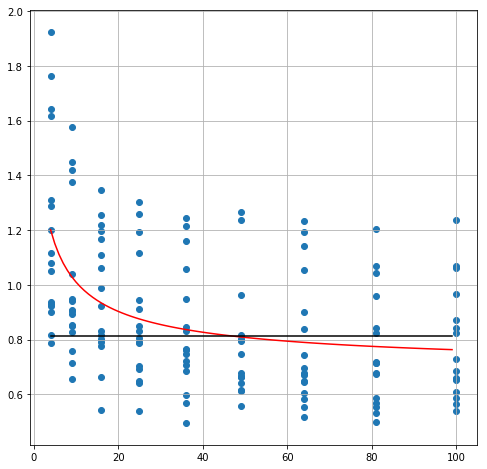

47


A Jupyter Widget

13


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


['PPFD_Avg']
12


A Jupyter Widget

In [ ]:
# pool.close()
Site = 'Illisarvik'#'FishIsland'#
cwd = os.getcwd()
FullModel = ['H','wind_speed','air_pressure','PPFD_Avg','AirTC_Avg',
             'VPD','Temp','VWC','Sedge','Shrub','Grass','Sparse','Out_of_Basin']
# FullModel = ['PPFD_Avg','AirTC_Avg','Sedge']

# FullModel = ['H','Wind Spd','air pressure','Ta','Rn','PPFD','Rain','Water Table',
#         'Ts 2.5 cm','Ts 15 cm','VWC','Active Layer','24H Rain','Wtr Tbl Trnd']

# FullModel = ['H','Water Table','Wind Spd','Active Layer']


for FillVar in ['fco2','fch4']:
# FillVar = 'fch4'
    Time = time.time()
    #     Path = 'Data_Footprints_2018-06-12.csv'
    Runs,params = Dense.Params('Full',FillVar,MP=True)
    params['Dpath'] = cwd+'/'+Site+'/'
    if __name__=='__main__'and params['proc'] != 1:
        pool = Pool(processes=params['proc'],maxtasksperchild=75)
    else:pool=None
    print(params)
    params = N_Nodes(Runs,params,FullModel,plot=True)
    Best,Scores,ModelRuns = FactorTest(params,FullModel,Runs)
    Best_Fill(Best,Runs,Scores,params)

    Scores.to_csv(params['Dpath']+FillVar+'/GapFillingSummary.csv')
    ModelRuns.to_csv(params['Dpath']+FillVar+'/GapFilled.csv')
    print(params['N'])
    print(time.time()-Time)